In [1]:
# Adapted from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# for kaggle satellite image classification dataset https://www.kaggle.com/mahmoudreda55/satellite-image-classification
# and then basic active learning was applied.

from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from pytorch_finetuning_utils import train_model, train_model_given_numpy_arrays, initialize_model
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
import sys
sys.path.append("..")
from test_framework.model_interface import ModelInterface
from test_framework.tester import Tester
from utils.data_utils import get_kaggle_satellite_image_classification_dataset_as_numpy_arrays
import categorical_query_functions

PyTorch Version:  1.10.0
Torchvision Version:  0.11.1


# parameters

In [2]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "../data/kaggle_satellite_image_classification"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 3#15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Whether to use ~1/10 of the dataset (True) or the full dataset (False)
small_dataset = False

# parameters specific to active learning
active_learning_batch_size = 1
initial_train_data_fraction = 0.001
active_learning_loop_count = 20
# QUERY_FUNCTION = categorical_query_functions.MIN_MAX
# QUERY_FUNCTION = categorical_query_functions.MIN_MARGIN
# QUERY_FUNCTION = categorical_query_functions.MAX_ENTROPY
QUERY_FUNCTION = categorical_query_functions.RANDOM

# Flag for whether to print train loss and accuracy after each epoch.
train_verbose = False

# Load data

In [3]:
x_data,y_data = get_kaggle_satellite_image_classification_dataset_as_numpy_arrays()
order = np.random.permutation(len(x_data))
x_data, y_data = x_data[order], y_data[order]

# Initialize model

In [4]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 4, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
class ActiveLearningModel(ModelInterface):
    def __init__(self,model,name="no name provided",details="no details provided"):
        model.to(device)
        self.model = model
        self._name = name
        self._details = details
        # Gather the parameters to be optimized/updated in this run. If we are
        #  finetuning we will be updating all parameters. However, if we are
        #  doing feature extract method, we will only update the parameters
        #  that we have just initialized, i.e. the parameters with requires_grad
        #  is True.
        params_to_update = model.parameters()
        verbose = False
        if verbose:
            print("Params to learn:")
        if feature_extract:
            params_to_update = []
            for name,param in model.named_parameters():
                if param.requires_grad == True:
                    params_to_update.append(param)
                    if verbose:
                        print("\t",name)
        elif verbose:
            for name,param in model.named_parameters():
                if param.requires_grad == True:
                    print("\t",name)

        # Observe that all parameters are being optimized
        optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
        self._optimizer = optimizer_ft
        
        # store criterion
        self._criterion = nn.CrossEntropyLoss()

    def name(self) -> str:
        return self._name
    def details(self) -> str:
        return self._details
    def train(self, train_x:np.ndarray, train_y:np.ndarray) -> None:
        self.model = train_model_given_numpy_arrays(self.model, train_x, train_y, self._criterion, self._optimizer, num_epochs, batch_size, verbose=train_verbose)
    def predict(self, test_x:np.ndarray):
        self.model.eval()
        x_tensor = torch.tensor(test_x)
        dataset = TensorDataset(x_tensor)
        dataloader = DataLoader(dataset,batch_size=batch_size,num_workers=0,shuffle=False)
        preds_list = []
        for (inputs,) in dataloader:
            inputs = inputs.to(device)
            preds_list.append(self.model(inputs).cpu().detach().numpy())
        return np.vstack(preds_list)
    def query(self, unlabeled_data:np.ndarray, labeling_batch_size:int) -> np.ndarray:
        softmax = lambda x: np.exp(x)/np.sum(np.exp(x),axis=-1,keepdims=True)
        softmax_outputs = softmax(self.predict(unlabeled_data))
        indices = QUERY_FUNCTION(softmax_outputs,labeling_batch_size)
        return indices

In [7]:
y_data_onehot = np.zeros((y_data.size, y_data.max()+1))
y_data_onehot[np.arange(y_data.size),y_data] = 1

In [8]:
if small_dataset:
    tester = Tester(x_data[:600],y_data_onehot[:600])
else:
    tester = Tester(x_data,y_data_onehot)
tester.TRAINING_EPOCHS = num_epochs
tester.ACTIVE_LEARNING_BATCH_SIZE = active_learning_batch_size
tester.INITIAL_TRAIN_DATA_FRACTION = initial_train_data_fraction
tester.ACTIVE_LEARNING_LOOP_COUNT = active_learning_loop_count

In [9]:
# active_learning_model = ActiveLearningModel(model_ft,model_name,str(model_ft.classifier))
active_learning_model = ActiveLearningModel(model_ft,"random",str(model_ft.classifier))

In [10]:
tester.test_model(active_learning_model)

Test 0, Training Epoch 2: 100%|██████████| 20/20 [02:10<00:00,  6.55s/it]


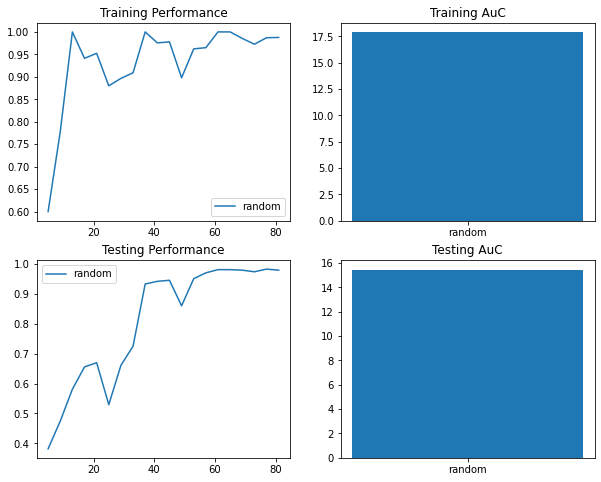

In [11]:
tester.plot_results()

In [12]:
print(tester.model_results[0].training_performance)
print(tester.model_results[0].test_performance)
print(tester.model_results[0].data_size)

[0.6, 0.7777777777777778, 1.0, 0.9411764705882353, 0.9523809523809523, 0.88, 0.896551724137931, 0.9090909090909091, 1.0, 0.975609756097561, 0.9777777777777777, 0.8979591836734694, 0.9622641509433962, 0.9649122807017544, 1.0, 1.0, 0.9855072463768116, 0.9726027397260274, 0.987012987012987, 0.9876543209876543]
[0.38188277087033745, 0.47424511545293074, 0.5808170515097691, 0.655417406749556, 0.6696269982238011, 0.5293072824156305, 0.6607773851590106, 0.7246891651865008, 0.9325044404973357, 0.9413854351687388, 0.9449378330373002, 0.8596802841918295, 0.9502664298401421, 0.9698046181172292, 0.9804618117229129, 0.9804618117229129, 0.9786856127886323, 0.9733570159857904, 0.9822380106571936, 0.9786856127886323]
[5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 81]


In [13]:
data_size = [5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 81]

# min margin
min_margin_train_perf = [0.8, 0.7777777777777778, 0.8461538461538461, 0.8235294117647058, 1.0, 0.92, 0.9655172413793104, 0.9696969696969697, 1.0, 0.975609756097561, 0.9555555555555556, 0.9183673469387755, 0.9811320754716981, 0.9824561403508771, 0.9344262295081968, 0.9846153846153847, 0.9420289855072463, 0.9315068493150684, 0.922077922077922, 0.9506172839506173]
min_margin_test_perf = [0.4422735346358792, 0.6181172291296625, 0.6820603907637656, 0.6198934280639432, 0.7211367673179396, 0.6927175843694494, 0.9182948490230906, 0.8632326820603907, 0.911190053285968, 0.9147424511545293, 0.9253996447602132, 0.9200710479573713, 0.9307282415630551, 0.9342806394316163, 0.9431616341030196, 0.9484902309058615, 0.9609236234458259, 0.9698046181172292, 0.9769094138543517, 0.9786856127886323]

# min max
min_max_train_perf = [0.6, 0.8888888888888888, 0.9230769230769231, 0.9411764705882353, 0.9523809523809523, 1.0, 0.9655172413793104, 0.8181818181818182, 0.972972972972973, 0.8780487804878049, 0.9777777777777777, 0.9183673469387755, 0.9245283018867925, 0.9298245614035088, 0.9508196721311475, 0.9384615384615385, 0.9420289855072463, 0.9726027397260274, 0.974025974025974, 0.9382716049382716]
min_max_test_perf = [0.31261101243339257, 0.5168738898756661, 0.6749555950266429, 0.7246891651865008, 0.6980461811722913, 0.8259325044404974, 0.8241563055062167, 0.6074600355239786, 0.8170515097690941, 0.7726465364120781, 0.8330373001776199, 0.8507992895204263, 0.8632326820603907, 0.8259325044404974, 0.866785079928952, 0.8809946714031972, 0.8792184724689165, 0.8916518650088809, 0.8969804618117229, 0.9520426287744227]

# max entropy
max_entropy_train_perf = [0.6, 0.7777777777777778, 1.0, 0.8823529411764706, 1.0, 1.0, 1.0, 0.9393939393939394, 0.8918918918918919, 1.0, 0.9777777777777777, 0.8979591836734694, 0.9811320754716981, 0.9649122807017544, 0.8688524590163934, 0.9384615384615385, 0.9710144927536232, 0.9726027397260274, 0.8961038961038961, 0.9382716049382716]
max_entropy_test_perf = [0.3285968028419183, 0.7442273534635879, 0.8010657193605684, 0.6873889875666075, 0.8117229129662522, 0.8383658969804618, 0.8863232682060391, 0.9307282415630551, 0.8206039076376554, 0.8454706927175843, 0.8934280639431617, 0.6980461811722913, 0.8809946714031972, 0.8792184724689165, 0.8294849023090586, 0.872113676731794, 0.8898756660746003, 0.8916518650088809, 0.8880994671403197, 0.9076376554174067]

# random
random_train_perf = [1.0, 0.7777777777777778, 0.9230769230769231, 1.0, 1.0, 1.0, 1.0, 0.9393939393939394, 0.9459459459459459, 0.9512195121951219, 0.9777777777777777, 0.9795918367346939, 1.0, 0.9824561403508771, 0.9836065573770492, 0.9846153846153847, 1.0, 0.9726027397260274, 0.987012987012987, 0.9753086419753086]
random_test_perf = [0.5399644760213144, 0.5435168738898757, 0.7566607460035524, 0.7744227353463587, 0.8738898756660746, 0.8419182948490231, 0.9236234458259325, 0.8188277087033747, 0.9094138543516874, 0.91651865008881, 0.9200710479573713, 0.9360568383658969, 0.9413854351687388, 0.9520426287744227, 0.9484902309058615, 0.9520426287744227, 0.9484902309058615, 0.955595026642984, 0.9573712255772646, 0.9573712255772646]


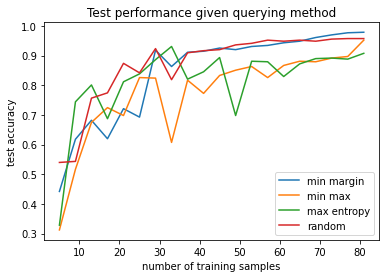

In [17]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(data_size,min_margin_test_perf,label='min margin')
plt.plot(data_size,min_max_test_perf,label='min max')
plt.plot(data_size,max_entropy_test_perf,label='max entropy')
plt.plot(data_size,random_test_perf,label='random')
plt.legend()
plt.title('Test performance given querying method')
plt.ylabel("test accuracy")
plt.xlabel("number of training samples")
plt.show()